In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
tf.random.set_seed(42)
from sklearn.model_selection import train_test_split

In [3]:
image_size=256
batch_size=32
channels=3

In [4]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(image_size,image_size),
    batch_size=batch_size
)

Found 2152 files belonging to 3 classes.


In [5]:
classes = dataset.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

Below code snippet iterates over a dataset, taking one batch of images and labels. It then prints the shape of the first image in that batch.
<br>1. for image_batch, label_batch in dataset.take(1): This loop fetches one batch of images and their corresponding labels from the dataset.
<br>2. print(image_batch[0].shape): This line prints the shape (dimensions) of the first image in the fetched batch.
In essence, it retrieves a single batch from the dataset and outputs the dimensions of the first image in that batch.

In [7]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


This will help us to plot an image, plt.imshow uses 3D array and as our dataset is tf, we convert it to numpy. 

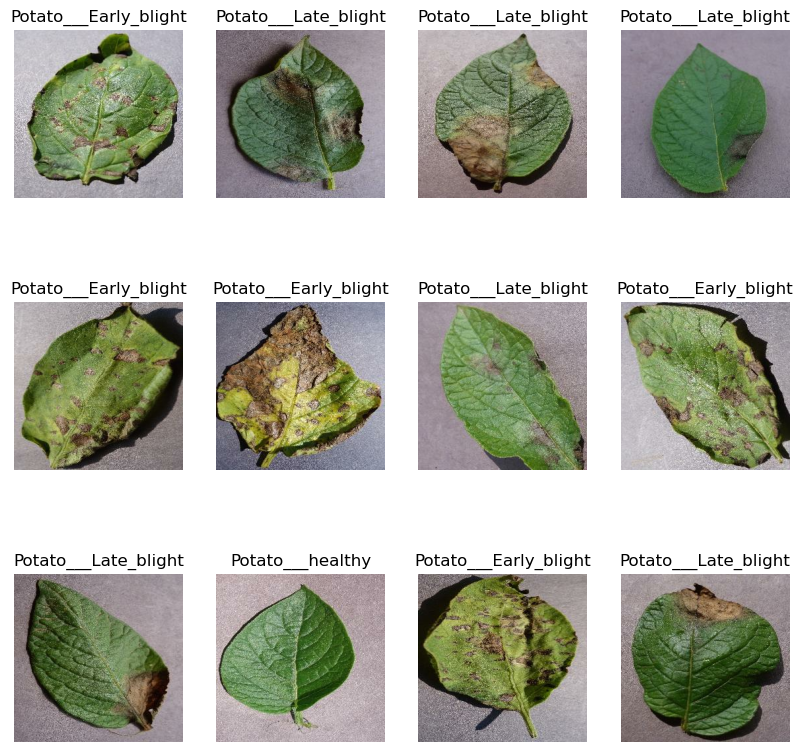

In [8]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("int"))
        plt.axis("off")
        plt.title(classes[label_batch[i]])

In [9]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds=dataset.take(54)

In [11]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [12]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_set=test_ds.take(6)
len(val_set)

6

In [14]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=42)
        
    train_size= int(train_split* ds_size)
    val_size= int(val_split* ds_size)
    
    train_ds=ds.take(train_size)   # Take the training data from dataset
    
    val_ds=ds.skip(train_size).take(val_size) #Skip the data taken in train, and take the data from val_size
    
    test_ds=ds.skip(train_size).skip(val_size)#Skip the data from both train and val, the remaining will be test
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


In [18]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
resize_and_rescale=tf.keras.Sequential([
    layers.Resizing(image_size, image_size),
    layers.Rescaling(1.0 / 255)
])

In [20]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

Building CNN

In [21]:
model= tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu', input_shape=(batch_size,image_size,image_size,channels)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(3,activation='softmax')
])

model.build(input_shape=(batch_size,image_size,image_size,channels))

C:\Users\athar\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [22]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [24]:
history=model.fit(
            train_ds,
            epochs=4,
            batch_size=batch_size,
            verbose=1,
            validation_data=val_ds
        )

Epoch 1/4


C:\Users\athar\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:599: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


54/54 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.4709 - loss: 0.9322 - val_accuracy: 0.4583 - val_loss: 0.8683
Epoch 2/4
54/54 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.5207 - loss: 0.8368 - val_accuracy: 0.6667 - val_loss: 0.7918
Epoch 3/4
54/54 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.7525 - loss: 0.5614 - val_accuracy: 0.6979 - val_loss: 0.6620
Epoch 4/4
54/54 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7781 - loss: 0.4888 - val_accuracy: 0.8177 - val_loss: 0.4228


Text(0.5, 1.0, 'Train VS Validation Accuracy')

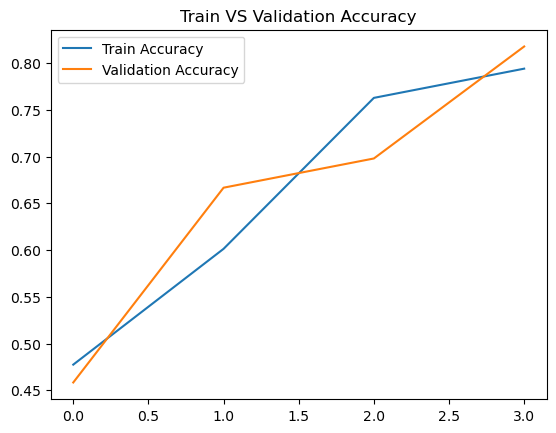

In [25]:
plt.plot(range(4),history.history['accuracy'],label='Train Accuracy')
plt.plot(range(4),history.history['val_accuracy'],label='Validation Accuracy')
plt.legend()
plt.title('Train VS Validation Accuracy')

In [26]:
scores=model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 261ms/step - accuracy: 0.7568 - loss: 0.4462


First image to predict
Actual Class Label:  Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
Predicted Label:  Potato___Early_blight


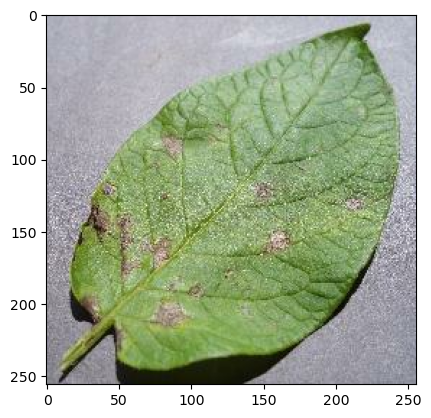

In [27]:
import numpy as np
for images_batch,label_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('int')
    first_label=label_batch[0]
    print('First image to predict')
    print('Actual Class Label: ',classes[first_label])
    plt.imshow(first_image)
    batch_prediction=model.predict(images_batch)
    print('Predicted Label: ',classes[np.argmax(batch_prediction[0])])

In [28]:
def predict(model, img):
    # Convert the image to an array
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    
    # Expand the dimensions of the image to match the model's input shape
    img_array = tf.expand_dims(img_array, 0)
    
    # Make a prediction using the model
    predictions = model.predict(img_array)
    
    # Get the class with the highest predicted probability
    predicted_class = classes[np.argmax(predictions[0])]
    
    # Calculate the confidence of the prediction
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    # Return the predicted class and confidence
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


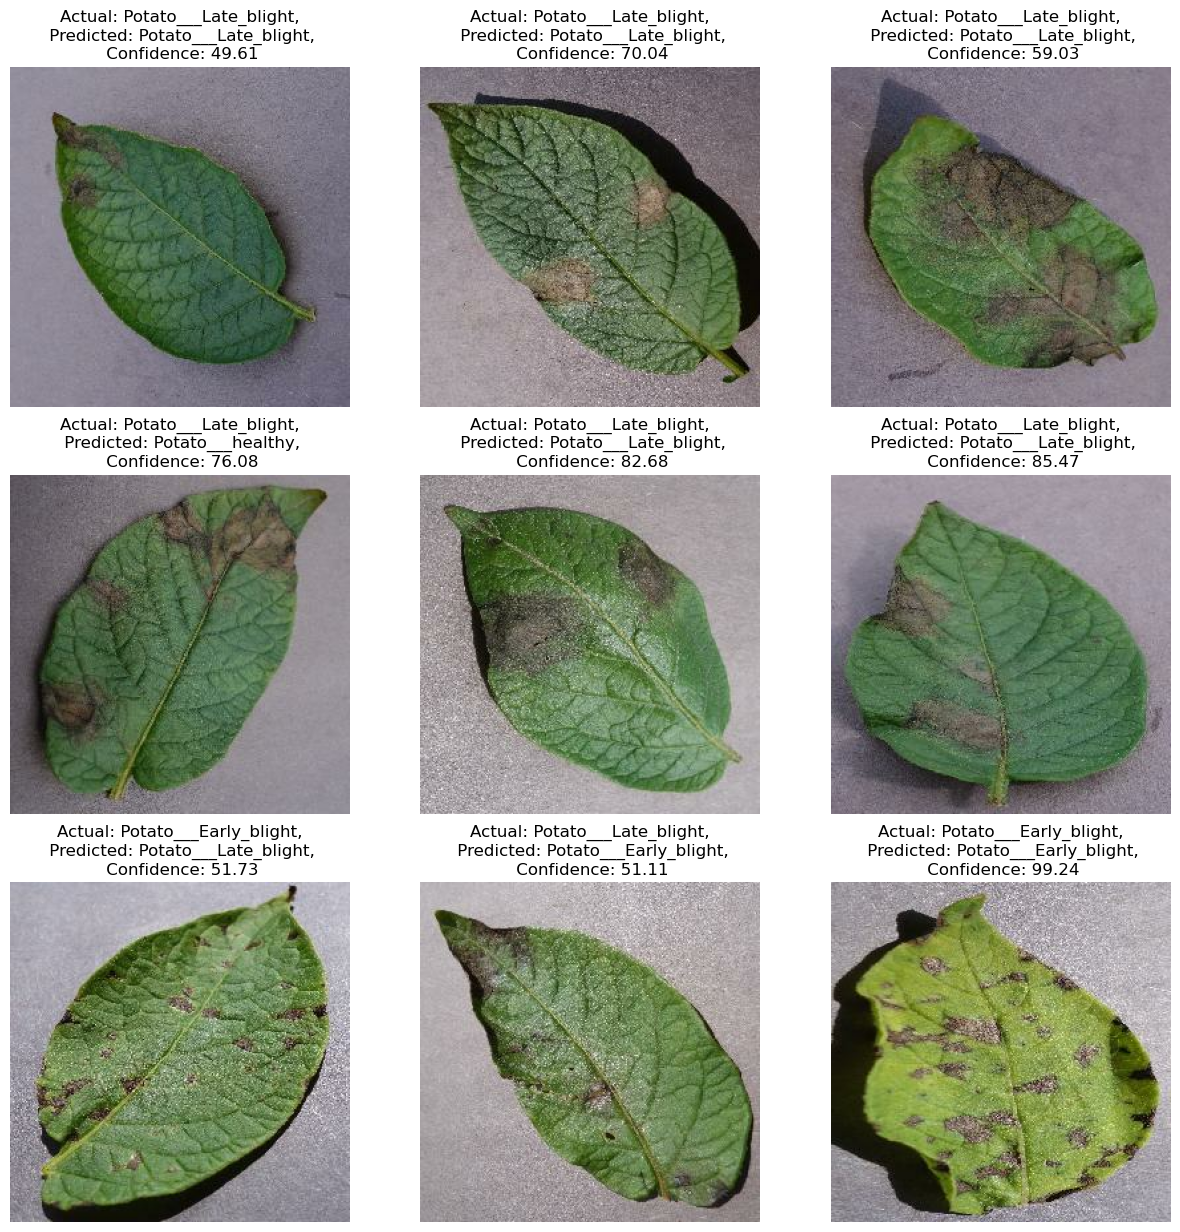

In [29]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.axis("off")
        predicted_class,confidence=predict(model,images[i].numpy())
        plt.title(f"Actual: {classes[labels[i]]},\n Predicted: {predicted_class},\n Confidence: {confidence}")

In [31]:
model.save("1.keras")